In [1]:
import torch
import onnx
import numpy as np
import onnxruntime as ort

import sys
import os
from pathlib import Path

sys.path.append('/home/nikita/e2e-driving')

from dataloading.nvidia import NvidiaValidationDataset
from ibc import optimizers

import logging

In [3]:
import torch.nn as nn

class IbcPilotNet(nn.Module):
    """
    PilotNet with action candidates (Implicit Behavior Cloning)
    https://implicitbc.github.io/
    """

    def __init__(self, samples=1024, iters=3, n_input_channels=3):
        super().__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.features = nn.Sequential(
            nn.Conv2d(n_input_channels, 24, 5, stride=2),
            nn.BatchNorm2d(24),
            nn.LeakyReLU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.BatchNorm2d(36),
            nn.LeakyReLU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(),
            nn.Conv2d(48, 64, 3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.regressor = nn.Sequential(
            nn.Linear(1664+1, 100), # plus one for target candidate
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Linear(100, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Linear(50, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 1),
        )

        inference_config = optimizers.DerivativeFreeConfig(
            bounds=self.get_target_bounds(),
            train_samples=0,
            inference_samples=samples,
            iters=iters,
        )
        
        self.stochastic_optimizer = optimizers.DFOptimizer.initialize(
            inference_config,
            'cpu',
        )

    def get_target_bounds(self):
        return torch.tensor([[-8.0], [8.0]]), # radians for ±450 degrees steering wheel rotation

    def _forward(self, x, y):
        logging.debug(f'x: {x.shape} {x.dtype}')
        logging.debug(f'y: {y.shape} {y.dtype}')
        out = self.features(x)
        logging.debug(f'after features(): {out.shape} {out.dtype}')
        fused = torch.cat([out.unsqueeze(1).expand(-1, y.size(1), -1), y], dim=-1)
        logging.debug(f'fused: {fused.shape} {fused.dtype}')
        B, N, D = fused.size()
        logging.debug(f'B, N, D: {B} {N} {D}')
        fused = fused.reshape(B * N, D)
        logging.debug(f'fused (reshaped): {fused.shape} {fused.dtype}')
        out = self.regressor(fused)
        logging.debug(f'output: {out.shape} {out.dtype}')
        return out.view(B, N)

    def forward(self, inputs):
        return self.stochastic_optimizer.infer(inputs, self._forward)
        

In [4]:
dataset_path = '/data/Bolt/dataset-new-small/summer2021'
batch_size = 256
num_workers = 16

validset = NvidiaValidationDataset(Path(dataset_path))
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False,
                                          num_workers=num_workers, pin_memory=True,
                                          persistent_workers=True)

/data/Bolt/dataset-new-small/summer2021/2021-05-28-15-19-48_e2e_sulaoja_20_30: lenght=10708, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-06-07-14-20-07_e2e_rec_ss6: lenght=25836, filtered=1
/data/Bolt/dataset-new-small/summer2021/2021-06-07-14-06-31_e2e_rec_ss6: lenght=3003, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-06-07-14-09-18_e2e_rec_ss6: lenght=4551, filtered=1
/data/Bolt/dataset-new-small/summer2021/2021-06-07-14-36-16_e2e_rec_ss6: lenght=25368, filtered=1
/data/Bolt/dataset-new-small/summer2021/2021-09-24-14-03-45_e2e_rec_ss11_backwards: lenght=25172, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-10-26-10-49-06_e2e_rec_ss20_elva: lenght=33045, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: lenght=33281, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-10-20-15-11-29_e2e_rec_vastse_ss13_17_back: lenght=26763, filtered=0
/data/Bolt/dataset-new-small/summer2021/2021-10-11-14-50-59_e2e_rec_va

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def save_model_to_onnx(model, model_path, data_loader):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.stochastic_optimizer.to(device)

    data = iter(data_loader).next()
    sample_inputs = create_onxx_input(data)
    output_path = Path(model_path).with_suffix('.onnx')

    torch.onnx.export(model, 
                      sample_inputs, 
                      output_path, 
                      input_names=['x'], 
                      dynamic_axes={'x': {0: 'batch_size'}}, 
                      do_constant_folding=False,
                      opset_version=9,
                      )
    onnx.checker.check_model(str(output_path))
    return str(output_path)

# def save_onnx_models(model, valid_loader):
#     save_model_to_onnx(model, f"{save_dir}/best.pt", valid_loader)
#     save_model_to_onnx(model, f"{save_dir}/last.pt", valid_loader)

def create_onxx_input(data):
    return data[0]['image'][0].unsqueeze(0).to(device)

# Convert to ONNX

In [7]:
# import importlib
# importlib.reload(optimizers)

pt_model_path = '/home/nikita/e2e-driving/models/20220618185552_steering-angle/last.pt'
pt_model = IbcPilotNet()

onnx_path = save_model_to_onnx(pt_model, pt_model_path, valid_loader)

/home/nikita/miniconda3/envs/e2e2/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:2905: UserWarning: Exporting aten::index operator of advanced indexing in opset 9 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn("Exporting aten::index operator of advanced indexing in opset " +


# Test-drive the result

In [6]:
data = iter(valid_loader).next()
sample_inputs = create_onxx_input(data)

onnx_input = {'x': sample_inputs.cpu().numpy()}
torch_input = sample_inputs.to(device)

In [31]:
# onnx
onnx_model = ort.InferenceSession(onnx_path, providers=["CUDAExecutionProvider"])

# torch
torch_model = IbcPilotNet()
torch_model.load_state_dict(torch.load(pt_model_path))
torch_model.to(device)
torch_model.stochastic_optimizer.to(device)
torch_model.eval()

loaded models!


In [32]:
%%timeit

onnx_model.run(None, onnx_input)[0]

3.45 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit

torch_model(torch_input)

6.45 ms ± 65.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### be careful, takes a while (~2 min)

In [29]:
onnx_results = []
torch_results = []

for i in range(10000):
  onnx_result = onnx_model.run(None, onnx_input)[0]
  torch_result = torch_model(torch_input)

  onnx_results.append(onnx_result)
  torch_results.append(torch_result)

print(f'onnx:', np.std(onnx_results), np.mean(onnx_results))
print(f'torch:', torch.std_mean(torch.as_tensor(torch_results)))

onnx: 0.00019857385 -0.3579694
torch: (tensor(0.0002), tensor(-0.3580))


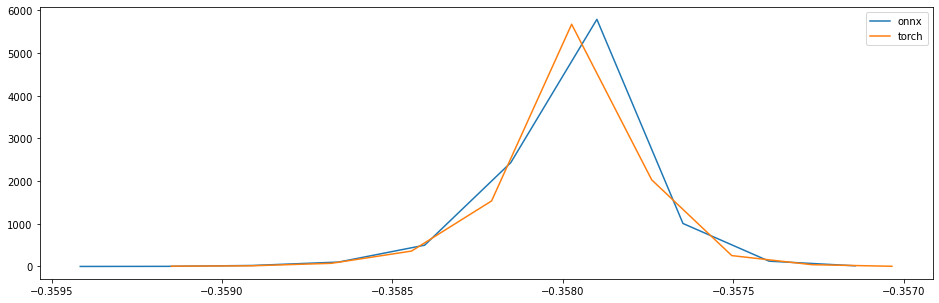

In [30]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 5))

bins = 10

s = onnx_results
p, x = np.histogram(s, bins=bins)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=bins)
plt.plot(x, f(x), label='onnx')

s = [r.cpu().numpy() for r in torch_results]
p, x = np.histogram(s, bins=bins)
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=bins)
plt.plot(x, f(x), label='torch')

plt.legend()
plt.show()